# Import dependancies

In [66]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# For BLEU and chrF
import sacrebleu

# For BERTScore
from bert_score import score

# For COMET
from comet import download_model, load_from_checkpoint

tqdm.pandas()


# Define metrics

In [59]:
llm_translator_name = "GEMINI"
# llm_translator_name = "GPT4O"
# llm_translator_name = "LLAMA3"


In [47]:
def load_comet_model():
    comet_model_path = download_model("Unbabel/wmt22-comet-da")
    comet_model = load_from_checkpoint(comet_model_path)
    return comet_model

comet_scorer = load_comet_model()


Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/Users/tami/Downloads/Master/Translation-with-LLMs/venv/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [103]:
def compute_sentence_bleu(reference, hypothesis):
    """
    Compute sentence-level BLEU score using sacrebleu.
    """
    bleu = sacrebleu.sentence_bleu(hypothesis, [reference])
    return bleu.score

def compute_sentence_chrf(reference, hypothesis):
    """
    Compute sentence-level chrF score using sacrebleu.
    """
    chrf = sacrebleu.sentence_chrf(hypothesis, [reference])
    return chrf.score


def compute_bertscore(references, hypotheses, lang):
    """
    Compute BERTScore F1 for a list of references and hypotheses.
    """
    P, R, F1 = score(hypotheses, references, lang=language_mapping.get(lang, 'en'), verbose=False)
    return F1.tolist()


def compute_comet_scores(src_sentences, references, hypotheses):
    """
    Compute COMET scores for a list of source, reference, and hypothesis sentences.
    """
    # Prepare input for COMET
    comet_input = [
        {"src": src, "mt": hyp, "ref": ref}
        for src, hyp, ref in zip(src_sentences, hypotheses, references)
    ]
    # Predict COMET scores
    comet_scores = comet_scorer.predict(comet_input)
    # Extract scores
    return comet_scores["scores"]
    # return [score['score'] for score in comet_scores]


# Collect Evaluation Metrics
1. BLEU
2. COMET
3. chrF
4. BertScore

In [49]:
df = pd.read_csv('../data/GEMINI_data.csv')
df

,eng,fra,arb,azj,fra_base_translation,arb_base_translation,azj_base_translation,eng_context,fra_context,arb_context,azj_context,fra_mcqa,arb_mcqa,azj_mcqa,fra_translate_with_context,arb_translate_with_context,azj_translate_with_context
0,Although three people were inside the house wh...,Bien que trois personnes aient été présentes d...,بالرغم من تواجد ثلاثة أشخاص داخل البيت عند اصط...,Maşın evə girən zaman evdə olan üç adamın heç ...,Bien que trois personnes se trouvaient dans la...,على الرغم من وجود ثلاثة أشخاص داخل المنزل عندم...,Maşın evin divarına dəyəndə evdə üç nəfər olsa...,The screech of tires was followed by a deafeni...,Un crissement de pneus a été suivi d'un choc a...,صوت صرير الإطارات تلاه اصطدام مدوٍّ. ظهرت سيا...,Təkərlərin dəhşətli səsi kar edici bir partlay...,Bien que trois personnes se trouvaient à l'int...,على الرغم من وجود ثلاثة أشخاص داخل المنزل عندم...,Avtomobil evinə dəyəndə içəridə üç nəfər olsa ...,Bien que trois personnes se trouvaient dans la...,على الرغم من وجود ثلاثة أشخاص داخل المنزل عندم...,"Maşın evə dəyəndə içəridə üç nəfər olsa da, on..."
1,34 per cent of those in the poll share this vi...,34 % des personnes interrogées partagent ce po...,يوافق 34 في المئة من الذين شملهم الاستبيان على...,Kraliçə II Yelizavetanın Avstraliyanın son kra...,34 % des personnes interrogées partagent ce po...,34% ممن شملهم الاستطلاع يشاركون هذا الرأي، حيث...,Sorğuda iştirak edənlərin 34 faizi bu fikri bö...,The recent poll revealed a surprising level of...,Un récent sondage a révélé un niveau surprenan...,كشفت استطلاعات الرأي الأخيرة عن مستوى مُفاجئ م...,Son sorğu Avstraliya əhalisi arasında təəccübl...,34 % des personnes interrogées partagent ce po...,ويُشارك 34% من المشاركين في الاستطلاع هذا الرأ...,Sorğuda iştirak edənlərin 34 faizi bu fikri bö...,34 % des personnes interrogées partagent ce po...,أعرب ٣٤٪ من المشاركين في الاستطلاع عن هذا الرأ...,Sorğuda iştirak edənlərin 34 faizi bu fikri bö...
2,The qualities that determine a subculture as d...,Les critères qui déterminent une sous-culture ...,ربما تكون الصفات التي تحدد تميز ثقافة فرعية هي...,Bir alt mədəniyyəti ayrıca təsnifləndirən cəhə...,Les qualités qui déterminent une sous-culture ...,الخصائص التي تحدد ثقافة فرعية مميزة قد تكون لغ...,Ayrı bir submədəniyyəti müəyyən edən keyfiyyət...,Understanding the complexities of societal str...,Comprendre la complexité des structures sociét...,يفهم تعقيدات الهياكل الاجتماعية يتطلب إدراك وج...,Cəmiyyət quruluşunun mürəkkəbliyini anlamaq üç...,Les qualités qui déterminent une sous-culture ...,الصفات التي تحدد ثقافة فرعية مميزة قد تكون لغو...,Submədəniyyəti fərqli olaraq müəyyən edən keyf...,Les qualités qui déterminent une sous-culture ...,الصفات التي تُميّز ثقافة فرعية على أنها متميزة...,"Subkulturu fərqləndirən xüsusiyyətlər dil, est..."
3,New Kingdom ancient Egyptians marvelled at the...,Les Égyptiens antiques du Nouvel Empire étaien...,اندهش المصريون القدامى في المملكة الحديثة من آ...,Qədim misirlilərin yeni Krallığı o zaman artıq...,Les anciens Égyptiens du Nouvel Empire s'émerv...,أعجب المصريون القدماء في المملكة الحديثة بمعال...,Yeni Krallıq qədim Misirliləri onlardan min il...,The sun beat down on the bustling city of Theb...,Le soleil tapait sur la ville animée de Thèbes...,ساطعت الشمس على مدينة طيبة الصاخبة، بعيدة كل ا...,"Fiyavın günəşi, qədim piramidaların sakit ehti...",Les anciens Égyptiens du Nouvel Empire s'émerv...,لقد تعجب المصريون القدماء في المملكة الحديثة م...,"2. Yeni Krallıq qədim Misirliləri, o zaman mi...",Les anciens Égyptiens du Nouvel Empire s'émerv...,أعجب المصريون القدماء في المملكة الحديثة بمعال...,Yeni Krallıq dövrünün qədim Misirliləri onlard...
4,The U.S. Corps of Engineers estimated that 6 i...,"D’après le U.S. Corps of Engineers, une pluvio...",قدر سلاح المهندسين الأمريكيين أن 6 بوصات من ال...,Amerika Birləşmiş Ştatlarının Mühəndislər Birl...,Le Corps des ingénieurs de l'armée américaine ...,قدرت هيئة المهندسين بالجيش الأمريكي أن 6 بوصات...,ABŞ-ın Mühəndislər Korpusu 6 düym yağışın əvvə

In [105]:
# Mapping for BERTScore language codes
language_mapping = {
    'fra': 'fr',  # French
    'arb': 'ar',  # Arabic
    'azj': 'az'   # Azerbaijani
}

# Define languages and corresponding columns
languages = {
    'fra': {
        'ground_truth': 'fra',
        'methods': {
            'baseline': 'fra_base_translation',
            'mcqa': 'fra_mcqa',
            'translate_with_context': 'fra_translate_with_context'
        }
    },
    'arb': {
        'ground_truth': 'arb',
        'methods': {
            'baseline': 'arb_base_translation',
            'mcqa': 'arb_mcqa',
            'translate_with_context': 'arb_translate_with_context'
        }
    },
    'azj': {
        'ground_truth': 'azj',
        'methods': {
            'baseline': 'azj_base_translation',
            'mcqa': 'azj_mcqa',
            'translate_with_context': 'azj_translate_with_context'
        }
    }
}


> Computing Metrics for All Methods and Languages

In [106]:
for lang_code, lang_data in languages.items():
    ground_truth_col = lang_data['ground_truth']
    src_col = 'eng'  # Assuming 'eng' is the source language column
    ground_truths = df[ground_truth_col].tolist()
    src_sentences = df[src_col].tolist()
    
    for method, translation_col in lang_data['methods'].items():
        hypotheses = df[translation_col].tolist()
        method_identifier = f"{lang_code}_{method}"
        
        print(f"Computing metrics for Language: {lang_code.upper()}, Method: {method}")
        
        # Compute BLEU
        df[f'BLEU_{method_identifier}'] = df.progress_apply(
            lambda row: compute_sentence_bleu(row[ground_truth_col], row[translation_col]),
            axis=1
        )
        
        # Compute chrF
        df[f'chrF_{method_identifier}'] = df.progress_apply(
            lambda row: compute_sentence_chrf(row[ground_truth_col], row[translation_col]),
            axis=1
        )
        
        # Compute BERTScore
        # Since BERTScore is computed in batches, it's more efficient to compute once per method
        # Therefore, we'll skip per-row computation and compute for all sentences at once
        bertscore = compute_bertscore(ground_truths, hypotheses, lang_code)
        df[f'BERTScore_{method_identifier}'] = bertscore
        
        # Compute COMET
        comet_scores = compute_comet_scores(src_sentences, ground_truths, hypotheses)
        df[f'COMET_{method_identifier}'] = comet_scores

# Display the updated DataFrame with new metric columns
df.head()


Computing metrics for Language: FRA, Method: baseline




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/tami/Downloads/Master/Translation-with-LLMs/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.

redicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:41<00:00,  5.88s/it]

Computing metrics for Language: FRA, Method: mcqa




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/tami/Downloads/Master/Translation-with-LLMs/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.

redicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:46<00:00,  6.59s/it]

Computing metrics for Language: FRA, Method: translate_with_context




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/tami/Downloads/Master/Translation-with-LLMs/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.

redicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:47<00:00,  6.75s/it]

Computing metrics for Language: ARB, Method: baseline




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/tami/Downloads/Master/Translation-with-LLMs/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.

redicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:36<00:00,  5.28s/it]

Computing metrics for Language: ARB, Method: mcqa




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/tami/Downloads/Master/Translation-with-LLMs/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.

redicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:46<00:00,  6.61s/it]

Computing metrics for Language: ARB, Method: translate_with_context




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/tami/Downloads/Master/Translation-with-LLMs/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.

redicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:44<00:00, 14.86s/it]

Computing metrics for Language: AZJ, Method: baseline




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/tami/Downloads/Master/Translation-with-LLMs/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.

redicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:36<00:00,  5.20s/it]

Computing metrics for Language: AZJ, Method: mcqa




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/tami/Downloads/Master/Translation-with-LLMs/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.

redicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:51<00:00,  7.38s/it]

Computing metrics for Language: AZJ, Method: translate_with_context




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/tami/Downloads/Master/Translation-with-LLMs/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.

redicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:37<00:00,  5.41s/it]

,eng,fra,arb,azj,fra_base_translation,arb_base_translation,azj_base_translation,eng_context,fra_context,arb_context,...,BERTScore_azj_translate_with_context,COMET_fra_baseline,COMET_fra_mcqa,COMET_fra_translate_with_context,COMET_arb_baseline,COMET_arb_mcqa,COMET_arb_translate_with_context,COMET_azj_baseline,COMET_azj_mcqa,COMET_azj_translate_with_context
0,Although three people were inside the house wh...,Bien que trois personnes aient été présentes d...,بالرغم من تواجد ثلاثة أشخاص داخل البيت عند اصط...,Maşın evə girən zaman evdə olan üç adamın heç ...,Bien que trois personnes se trouvaient dans la...,على الرغم من وجود ثلاثة أشخاص داخل المنزل عندم...,Maşın evin divarına dəyəndə evdə üç nəfər olsa...,The screech of tires was followed by a deafeni...,Un crissement de pneus a été suivi d'un choc a...,صوت صرير الإطارات تلاه اصطدام مدوٍّ. ظهرت سيا...,...,0.840374,0.924625,0.880727,0.891056,0.928533,0.886209,0.926606,0.928679,0.851661,0.926248
1,34 per cent of those in the poll share this vi...,34 % des personnes interrogées partagent ce po...,يوافق 34 في المئة من الذين شملهم الاستبيان على...,Kraliçə II Yelizavetanın Avstraliyanın son kra...,34 % des personnes interrogées partagent ce po...,34% ممن شملهم الاستطلاع يشاركون هذا الرأي، حيث...,Sorğuda iştirak edənlərin 34 faizi bu fikri bö...,The recent poll revealed a surprising level of...,Un récent sondage a révélé un niveau surprenan...,كشفت استطلاعات الرأي الأخيرة عن مستوى مُفاجئ م...,...,0.769316,0.886238,0.853176,0.938924,0.922427,0.813275,0.898971,0.928695,0.859954,0.938460
2,The qualities that determine a subculture as d...,Les critères qui déterminent une sous-culture ...,ربما تكون الصفات التي تحدد تميز ثقافة فرعية هي...,Bir alt mədəniyyəti ayrıca təsnifləndirən cəhə...,Les qualités qui déterminent une sous-culture ...,الخصائص التي تحدد ثقافة فرعية مميزة قد تكون لغ...,Ayrı bir submədəniyyəti müəyyən edən keyfiyyət...,Understanding the complexities of societal str...,Comprendre la complexité des structures sociét...,يفهم تعقيدات الهياكل الاجتماعية يتطلب إدراك وج...,...,0.833193,0.935949,0.935949,0.935949,0.938643,0.946526,0.922925,0.925690,0.912958,0.932419
3,New Kingdom ancient Egyptians marvelled at the...,Les Égyptiens antiques du Nouvel Empire étaien...,اندهش المصريون القدامى في المملكة الحديثة من آ...,Qədim misirlilərin yeni Krallığı o zaman artıq...,Les anciens Égyptiens du Nouvel Empire s'émerv...,أعجب المصريون القدماء في المملكة الحديثة بمعال...,Yeni Krallıq qədim Misirliləri onlardan min il...,The sun beat down on the bustling city of Theb...,Le soleil tapait sur la ville animée de Thèbes...,ساطعت الشمس على مدينة طيبة الصاخبة، بعيدة كل ا...,...,0.757177,0.928423,0.816548,0.923332,0.899749,0.906106,0.894129,0.807579,0.823279,0.886152
4,The U.S. Corps of Engineers estimated that 6 i...,"D’après le U.S. Corps of Engineers, une pluvio...",قدر سلاح المهندسين الأمريكيين أن 6 بوصات من ال...,Amerika Birləşmiş Ştatlarının Mühəndislər Birl...,Le Corps des ingénieurs de l'armée américaine ...,قدرت هيئة المهندسين بالجيش الأمريكي أن 6 بوصات...,ABŞ-ın Mühəndislər Korpusu 6 düym yağışın əvvə...,The impending storm had everyone on edge. For...,L'orage imminent mettait tout le monde sur les...,العاصفة المُحدقة جعلت الجميع في حالة توتر. توق...,...,0.776482,0.709365,0.723402,0.690468,0.891732,0.838462,0.866495,0.898060,0.229822,0.880746


In [108]:
metric_columns = [col for col in df.columns if col.startswith(('BLEU_', 'chrF_', 'BERTScore_', 'COMET_'))]
metrics_df = df[metric_columns]
metrics_df.to_csv(f'../results/{llm_translator_name}/metrics.csv')
metrics_df.describe()


,BLEU_fra_baseline,chrF_fra_baseline,BERTScore_fra_baseline,BLEU_fra_mcqa,chrF_fra_mcqa,BERTScore_fra_mcqa,BLEU_fra_translate_with_context,chrF_fra_translate_with_context,BERTScore_fra_translate_with_context,BLEU_arb_baseline,...,BERTScore_azj_translate_with_context,COMET_fra_baseline,COMET_fra_mcqa,COMET_fra_translate_with_context,COMET_arb_baseline,COMET_arb_mcqa,COMET_arb_translate_with_context,COMET_azj_baseline,COMET_azj_mcqa,COMET_azj_translate_with_context
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.563335,71.770914,0.923469,39.463237,67.925678,0.884134,47.658189,71.041193,0.920414,26.991454,...,0.820871,0.890807,0.844212,0.889635,0.880625,0.833748,0.850409,0.890176,0.771253,0.892054
std,21.864627,14.591742,0.044831,20.409341,14.214341,0.057506,21.731723,14.322954,0.049645,17.329823,...,0.040390,0.060017,0.083085,0.064783,0.059888,0.096880,0.116175,0.054086,0.211199,0.053098
min,4.883351,33.149329,0.786615,1.183609,14.702940,0.732603,3.775099,29.350933,0.730249,1.851251,...,0.732839,0.709365,0.618698,0.601265,0.662000,0.210864,0.388775,0.626815,0.223854,0.659213
25%,33.868039,62.174154,0.898403,25.505564,59.627705,0.846919,31.609505,62.245148,0.901608,15.340758,...,0.791086,0.869915,0.806919,0.875455,0.859022,0.798697,0.839809,0.873635,0.768391,0.877295
50%,49.126149,72.103850,0.931486,36.642221,70.279430,0.889435,46.235129,71.262181,0.932251,23.192517,...,0.817616,0.906267,0.863544,0.907929,0.896340,0.854019,0.890525,0.906959,0.860468,0.909385
75%,65.524103,82.435683,0.953113,53.840758,75.911653,0.926116,62.626916,82.019349,0.952472,36.342997,...,0.848745,0.931862,0.906623,0.934376,0.921342,0.897366,0.914124,0.920638,0.899912,0.925899
max,100.000000,100.000000,1.000000,94.308563,98.808017,0.976916,100.000000,100.000000,1.000000,100.000000,...,0.921578,0.979610,0.951370,0.979610,0.979693,0.962345,0.963513,0.963129,0.958865,0.959393


In [109]:
import pandas as pd

# Step 1: Identify all metric columns
metric_prefixes = ['BLEU_', 'chrF_', 'BERTScore_', 'COMET_']
metric_columns = [col for col in df.columns if any(col.startswith(prefix) for prefix in metric_prefixes)]

# Step 2: Melt the DataFrame to long format
id_vars = ['eng', 'fra', 'arb', 'azj']
value_vars = metric_columns

df_long = df.melt(id_vars=id_vars, value_vars=value_vars,
                  var_name='Metric_Method', value_name='Score')

# Step 3: Split 'Metric_Method' into 'Metric', 'Language', 'Method'
df_long[['Metric', 'Language', 'Method']] = df_long['Metric_Method'].str.split('_', n=2, expand=True)

# Step 4: Drop the 'Metric_Method' column as it's no longer needed
df_long = df_long.drop(columns=['Metric_Method'])

# Optional: Reorder columns for better readability
df_long = df_long[['eng', 'fra', 'arb', 'azj', 'Metric', 'Language', 'Method', 'Score']]

# Display the transformed DataFrame
df_long.head()


,eng,fra,arb,azj,Metric,Language,Method,Score
0,Although three people were inside the house wh...,Bien que trois personnes aient été présentes d...,بالرغم من تواجد ثلاثة أشخاص داخل البيت عند اصط...,Maşın evə girən zaman evdə olan üç adamın heç ...,BLEU,fra,baseline,51.295864
1,34 per cent of those in the poll share this vi...,34 % des personnes interrogées partagent ce po...,يوافق 34 في المئة من الذين شملهم الاستبيان على...,Kraliçə II Yelizavetanın Avstraliyanın son kra...,BLEU,fra,baseline,40.862476
2,The qualities that determine a subculture as d...,Les critères qui déterminent une sous-culture ...,ربما تكون الصفات التي تحدد تميز ثقافة فرعية هي...,Bir alt mədəniyyəti ayrıca təsnifləndirən cəhə...,BLEU,fra,baseline,63.929388
3,New Kingdom ancient Egyptians marvelled at the...,Les Égyptiens antiques du Nouvel Empire étaien...,اندهش المصريون القدامى في المملكة الحديثة من آ...,Qədim misirlilərin yeni Krallığı o zaman artıq...,BLEU,fra,baseline,50.375290
4,The U.S. Corps of Engineers estimated that 6 i...,"D’après le U.S. Corps of Engineers, une pluvio...",قدر سلاح المهندسين الأمريكيين أن 6 بوصات من ال...,Amerika Birləşmiş Ştatlarının Mühəndislər Birl...,BLEU,fra,baseline,4.883351


# EDA

In [110]:
# Group by Language, Method, and Metric, then compute descriptive statistics
grouped_stats = df_long.groupby(['Language', 'Method', 'Metric']).agg(
    mean_score=('Score', 'mean'),
    std_score=('Score', 'std'),
    min_score=('Score', 'min'),
    max_score=('Score', 'max')
).reset_index()

# Display the descriptive statistics
print(grouped_stats)


   Language                  Method     Metric  mean_score  std_score  \
0       arb                baseline  BERTScore    0.881304   0.043652   
1       arb                baseline       BLEU   26.991454  17.329823   
2       arb                baseline      COMET    0.880625   0.059888   
3       arb                baseline       chrF   59.570977  13.413303   
4       arb                    mcqa  BERTScore    0.840590   0.060509   
5       arb                    mcqa       BLEU   18.784831  13.828120   
6       arb                    mcqa      COMET    0.833748   0.096880   
7       arb                    mcqa       chrF   54.926824  13.860446   
8       arb  translate_with_context  BERTScore    0.859826   0.068214   
9       arb  translate_with_context       BLEU   23.223581  17.097238   
10      arb  translate_with_context      COMET    0.850409   0.116175   
11      arb  translate_with_context       chrF   56.520400  14.356687   
12      azj                baseline  BERTScore    0

/var/folders/lx/7zqj2bsd3t31m_y7db8xr9380000gp/T/ipykernel_87583/1811873281.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_data = lang_data[grouped_stats['Metric'] == metric]
/var/folders/lx/7zqj2bsd3t31m_y7db8xr9380000gp/T/ipykernel_87583/1811873281.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/lx/7zqj2bsd3t31m_y7db8xr9380000gp/T/ipykernel_87583/1811873281.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_data = lang_data[grouped_stats['Metric'] == metric]
/var/folders/lx/7zqj2bsd3t31m_y7db8xr9380000gp/T/ipykernel_87583/1811873281.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot

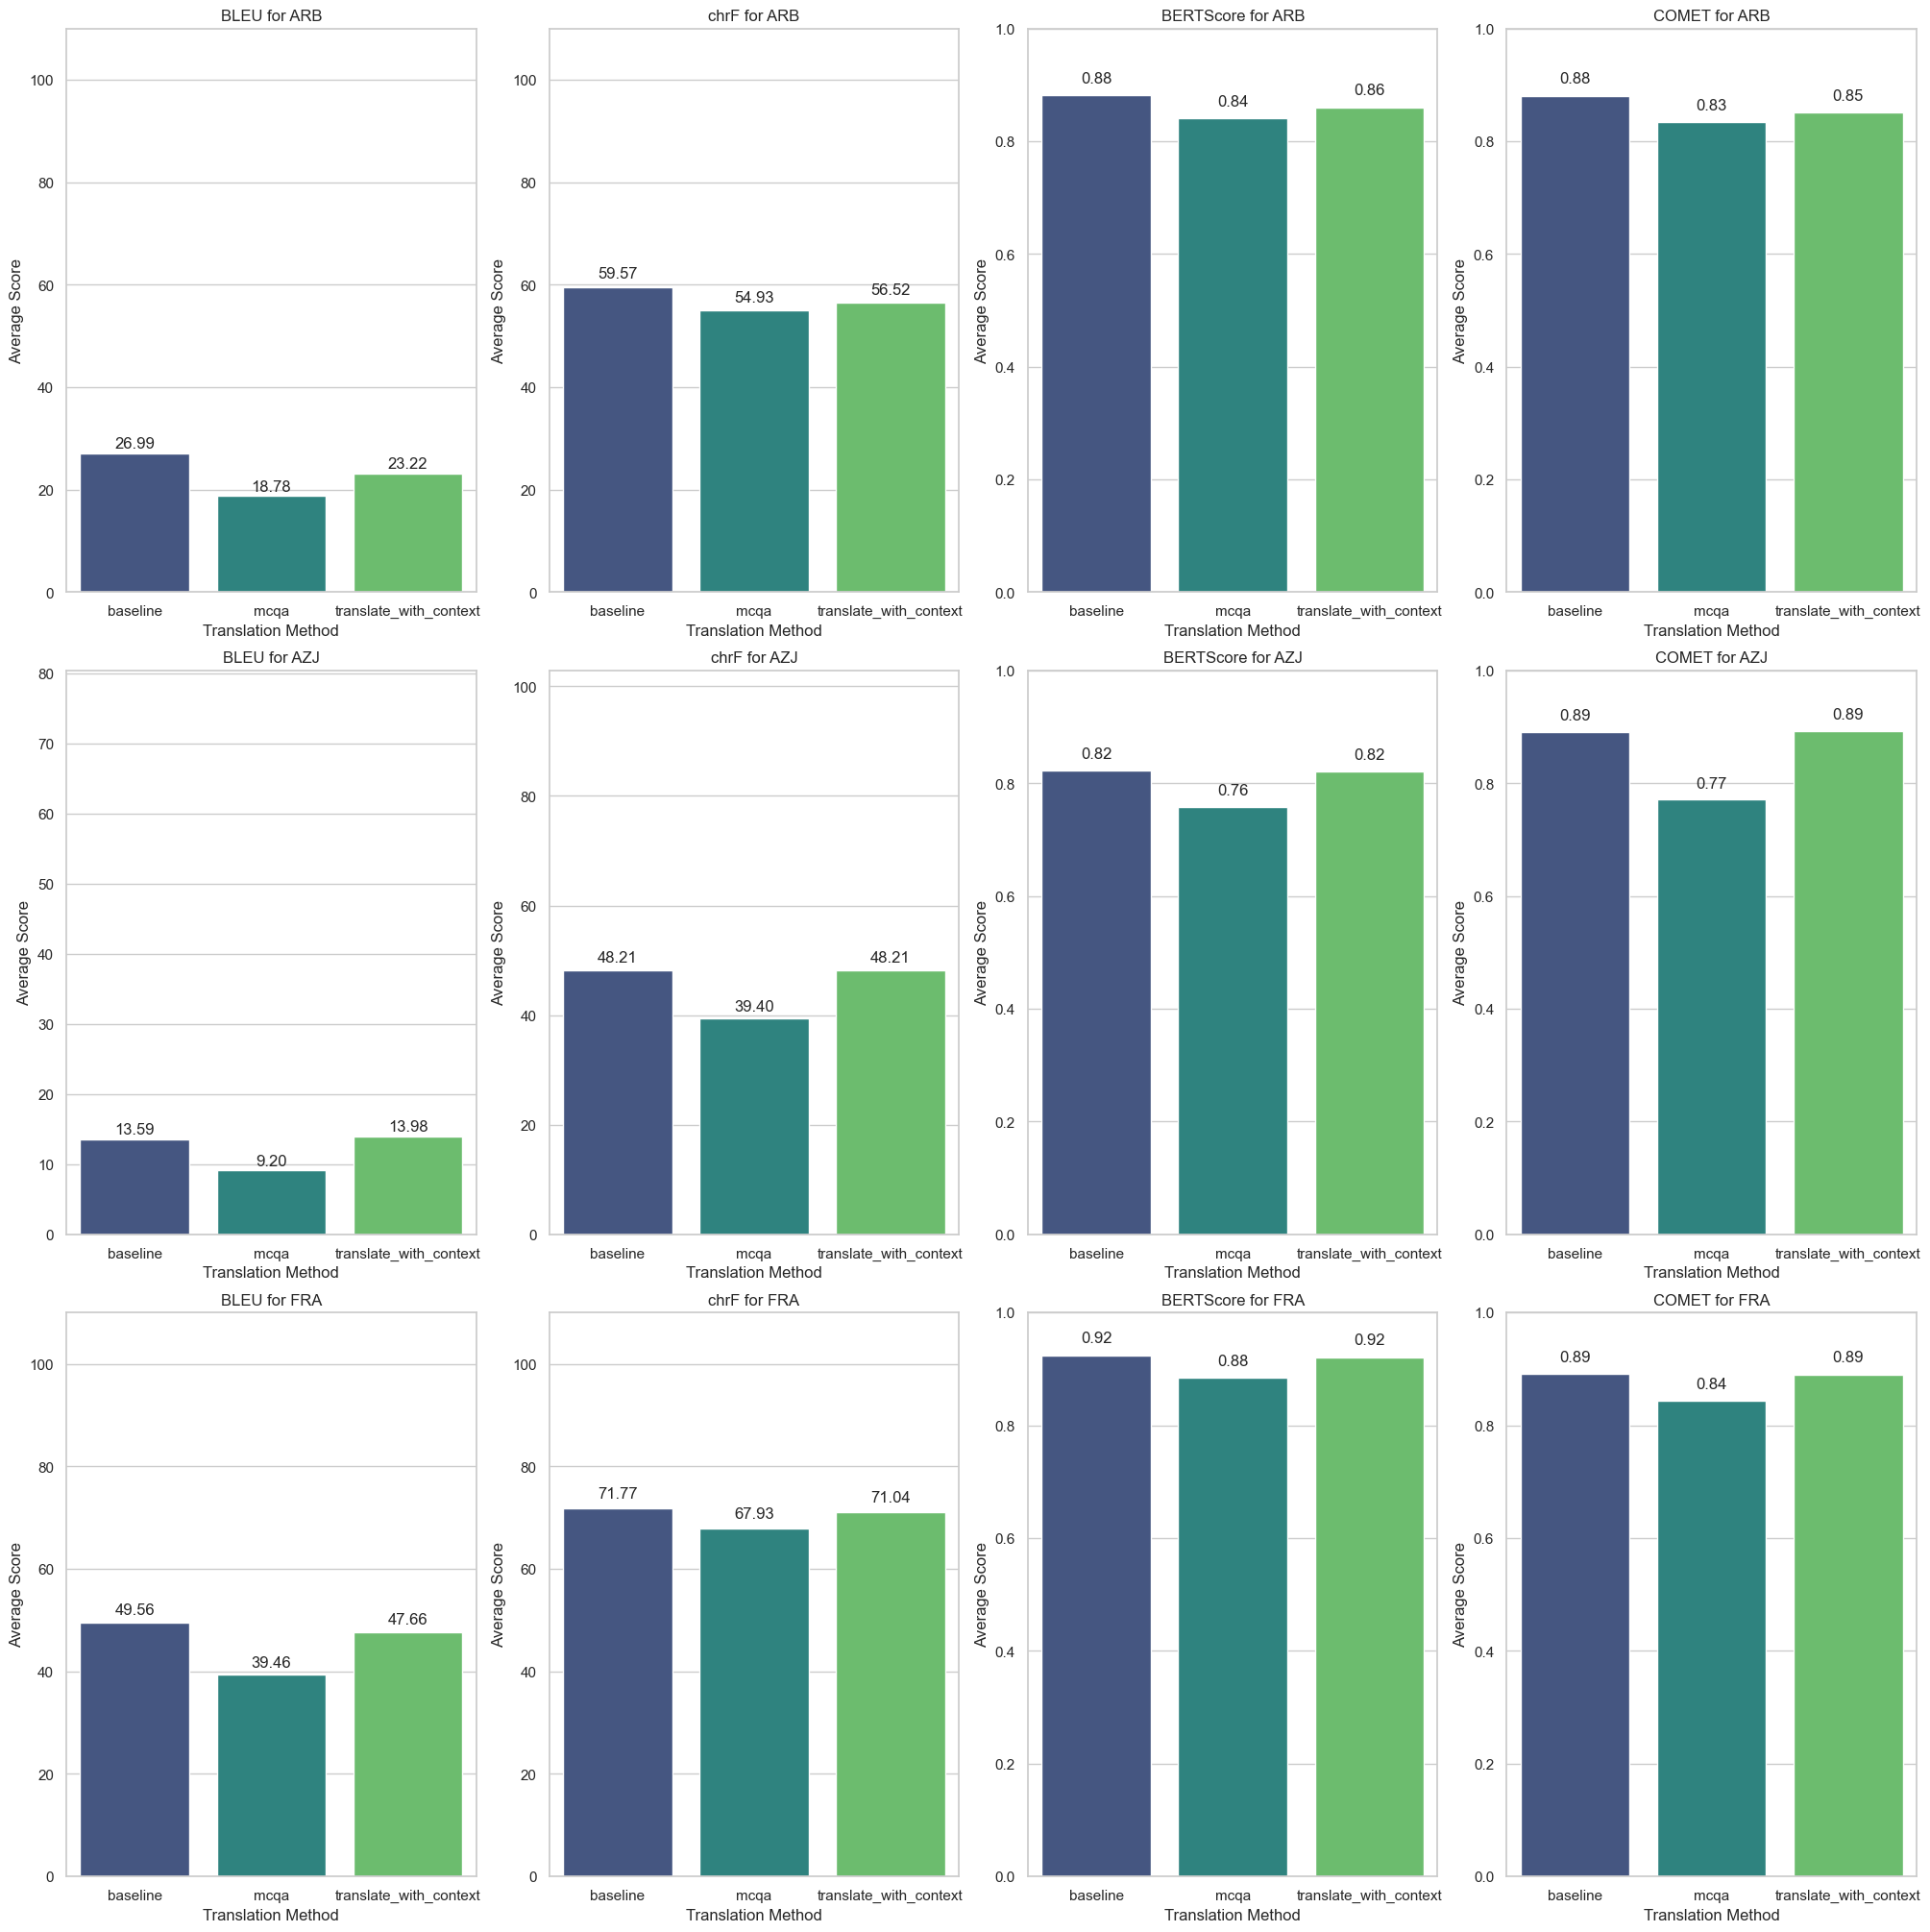

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style
sns.set(style="whitegrid")

# List of metrics
metrics = ['BLEU', 'chrF', 'BERTScore', 'COMET']

# Get unique languages and total plots
unique_languages = grouped_stats['Language'].unique()
num_plots = len(unique_languages) * len(metrics)

# Define the number of rows and columns for subplots
rows, cols = 3, 4  # Adjust based on your dataset
fig, axes = plt.subplots(rows, cols, figsize=(20, 20), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Counter to track which subplot to plot into
plot_idx = 0

# Iterate over each language and metric
for lang in unique_languages:
    lang_data = grouped_stats[grouped_stats['Language'] == lang]
    for metric in metrics:
        if plot_idx >= len(axes):
            break
        
        # Get subplot
        ax = axes[plot_idx]
        
        # Filter data for the metric
        metric_data = lang_data[grouped_stats['Metric'] == metric]
        
        # Plot the bar chart
        sns.barplot(
            data=metric_data,
            x='Method',
            y='mean_score',
            palette='viridis',
            ax=ax
        )
        
        # Add values on top of bars
        for bar in ax.patches:
            bar_height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2, 
                bar_height + (bar_height * 0.02 if bar_height > 0 else 0.05),  # Add a small offset based on bar height
                f'{bar_height:.2f}', 
                ha='center', 
                va='bottom'
            )
        
        # Set title and labels
        ax.set_title(f'{metric} for {lang.upper()}')
        ax.set_xlabel('Translation Method')
        ax.set_ylabel('Average Score')
        
        # Adjust y-axis limits
        if metric in ('BERTScore', 'COMET'):
            ax.set_ylim(0, 1)
        else:
            ax.set_ylim(0, metric_data['max_score'].max() + 10)
        
        plot_idx += 1

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].axis('off')

plt.show()



/var/folders/lx/7zqj2bsd3t31m_y7db8xr9380000gp/T/ipykernel_87583/4138053178.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/lx/7zqj2bsd3t31m_y7db8xr9380000gp/T/ipykernel_87583/4138053178.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/lx/7zqj2bsd3t31m_y7db8xr9380000gp/T/ipykernel_87583/4138053178.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/lx/7zqj2bsd3t31m_y7db8xr9380000gp/T/ipykernel_87583/4138053178.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

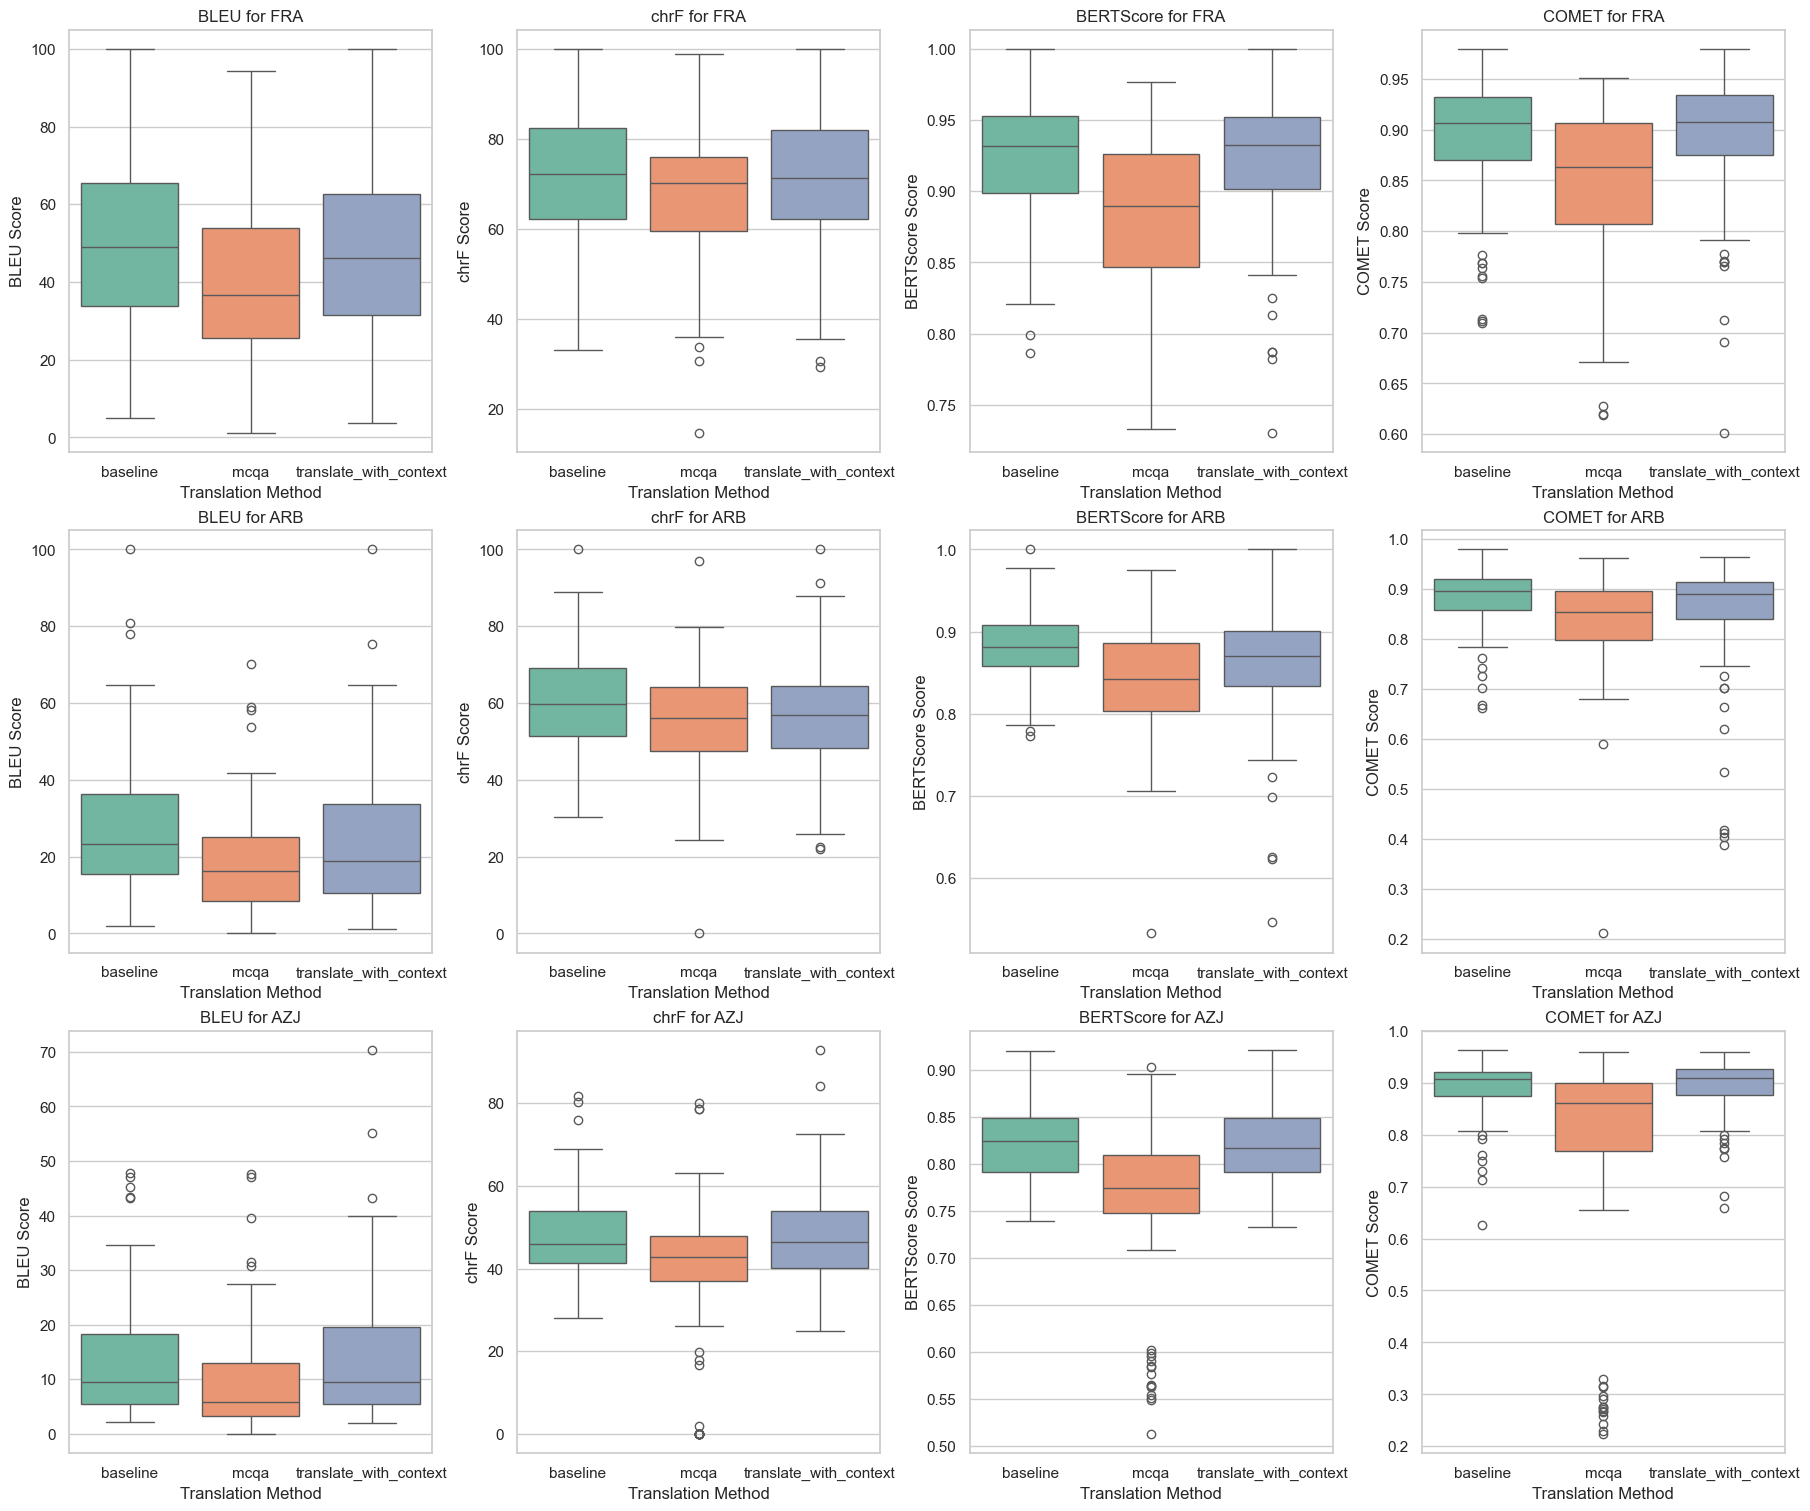

In [115]:
# List of metrics
metrics = ['BLEU', 'chrF', 'BERTScore', 'COMET']

# Get unique languages and total plots
unique_languages = df_long['Language'].unique()
num_plots = len(unique_languages) * len(metrics)

# Define the number of rows and columns for subplots
rows, cols = 3, 4  # Adjust grid size based on your dataset
fig, axes = plt.subplots(rows, cols, figsize=(18, 15), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Counter to track which subplot to plot into
plot_idx = 0

# Iterate over each language and metric
for lang in unique_languages:
    lang_data = df_long[df_long['Language'] == lang]
    for metric in metrics:
        if plot_idx >= len(axes):
            break
        
        # Get subplot
        ax = axes[plot_idx]
        
        # Filter data for the current language and metric
        metric_data = lang_data[lang_data['Metric'] == metric]
        
        # Plot the boxplot
        sns.boxplot(
            data=metric_data,
            x='Method',
            y='Score',
            palette='Set2',
            ax=ax
        )
        
        # Set title and labels
        ax.set_title(f'{metric} for {lang.upper()}')
        ax.set_xlabel('Translation Method')
        ax.set_ylabel(f'{metric} Score')
        
        plot_idx += 1

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].axis('off')

plt.show()



# Statistical Tests

In [116]:
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.multitest import multipletests

def shapiro_test(data):
    """Perform Shapiro-Wilk test for normality."""
    from scipy.stats import shapiro
    stat, p = shapiro(data)
    return stat, p

def perform_statistical_tests(df_long, language, metric, method1, method2):
    """
    Perform paired t-test or Wilcoxon signed-rank test between two methods for a given language and metric.
    
    Parameters:
    - df_long (DataFrame): Long-format DataFrame with metrics.
    - language (str): Language code (e.g., 'fra').
    - metric (str): Metric name (e.g., 'BLEU').
    - method1 (str): First method (e.g., 'baseline').
    - method2 (str): Second method (e.g., 'mcqa').
    
    Returns:
    - dict: Test results including test name, statistic, p-value.
    """
    # Extract scores for both methods
    scores1 = df_long[(df_long['Language'] == language) & 
                      (df_long['Metric'] == metric) & 
                      (df_long['Method'] == method1)]['Score']
    scores2 = df_long[(df_long['Language'] == language) & 
                      (df_long['Metric'] == metric) & 
                      (df_long['Method'] == method2)]['Score']
    
    # Ensure alignment by resetting index
    scores1 = scores1.reset_index(drop=True)
    scores2 = scores2.reset_index(drop=True)
    
    # Compute differences
    differences = scores2 - scores1
    
    # Check for normality
    stat, p_normal = shapiro_test(differences)
    
    if p_normal > 0.05:
        # Normally distributed, use paired t-test
        test_stat, p_val = ttest_rel(scores2, scores1)
        test_name = 'Paired t-Test'
    else:
        # Not normally distributed, use Wilcoxon signed-rank test
        test_stat, p_val = wilcoxon(scores2, scores1)
        test_name = 'Wilcoxon Signed-Rank Test'
    
    return {
        'Test': test_name,
        'Statistic': test_stat,
        'p-value': p_val
    }


In [117]:
from itertools import combinations

# Define the list of metrics
metrics = ['BLEU', 'chrF', 'BERTScore', 'COMET']

# Define the languages
languages = ['fra', 'arb', 'azj']

# Define the method pairs to compare
method_pairs = [
    ('baseline', 'mcqa'),
    ('baseline', 'translate_with_context'),
    ('mcqa', 'translate_with_context')
]

# Initialize a list to store all test results
all_test_results = []

for lang in languages:
    for (method1, method2) in method_pairs:
        for metric in metrics:
            test_result = perform_statistical_tests(df_long, lang, metric, method1, method2)
            all_test_results.append({
                'Language': lang.upper(),
                'Comparison': f"{method1} vs {method2}",
                'Metric': metric,
                'Test': test_result['Test'],
                'Statistic': test_result['Statistic'],
                'p-value': test_result['p-value']
            })

# Convert the results to a DataFrame
test_results_df = pd.DataFrame(all_test_results)

# Display the test results
test_results_df

,Language,Comparison,Metric,Test,Statistic,p-value
0,FRA,baseline vs mcqa,BLEU,Wilcoxon Signed-Rank Test,897.0,2.205119e-06
1,FRA,baseline vs mcqa,chrF,Wilcoxon Signed-Rank Test,1158.0,2.150547e-04
2,FRA,baseline vs mcqa,BERTScore,Wilcoxon Signed-Rank Test,474.0,1.475863e-10
3,FRA,baseline vs mcqa,COMET,Wilcoxon Signed-Rank Test,776.0,1.862502e-07
4,FRA,baseline vs translate_with_context,BLEU,Wilcoxon Signed-Rank Test,956.0,9.361088e-02
5,FRA,baseline vs translate_with_context,chrF,Wilcoxon Signed-Rank Test,1216.0,2.697509e-01
6,FRA,baseline vs translate_with_context,BERTScore,Wilcoxon Signed-Rank Test,1234.0,2.357749e-01
7,FRA,baseline vs translate_with_context,COMET,Wilcoxon Signed-Rank Test,1363.0,7.433695e-01
8,FRA,mcqa vs translate_with_context,BLEU,Wilcoxon Signed-Rank Test,1089.0,2.653372e-05
9,FRA,mcqa vs translate_with_context,chrF,Wilcoxon Signed-Rank Test,1281.0,5.288998e-04


# Adjusting for Multiple Comparisons
To control for the increased risk of Type I errors due to multiple comparisons, apply a multiple comparisons correction such as the Bonferroni correction.

In [118]:
# Extract p-values
p_values = test_results_df['p-value'].tolist()

# Apply Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')

# Add corrected p-values and significance to the DataFrame
test_results_df['p-value_corrected'] = pvals_corrected
test_results_df['Significant'] = reject

# Display the updated test results
test_results_df

,Language,Comparison,Metric,Test,Statistic,p-value,p-value_corrected,Significant
0,FRA,baseline vs mcqa,BLEU,Wilcoxon Signed-Rank Test,897.0,2.205119e-06,7.938429e-05,True
1,FRA,baseline vs mcqa,chrF,Wilcoxon Signed-Rank Test,1158.0,2.150547e-04,7.741968e-03,True
2,FRA,baseline vs mcqa,BERTScore,Wilcoxon Signed-Rank Test,474.0,1.475863e-10,5.313107e-09,True
3,FRA,baseline vs mcqa,COMET,Wilcoxon Signed-Rank Test,776.0,1.862502e-07,6.705007e-06,True
4,FRA,baseline vs translate_with_context,BLEU,Wilcoxon Signed-Rank Test,956.0,9.361088e-02,1.000000e+00,False
5,FRA,baseline vs translate_with_context,chrF,Wilcoxon Signed-Rank Test,1216.0,2.697509e-01,1.000000e+00,False
6,FRA,baseline vs translate_with_context,BERTScore,Wilcoxon Signed-Rank Test,1234.0,2.357749e-01,1.000000e+00,False
7,FRA,baseline vs translate_with_context,COMET,Wilcoxon Signed-Rank Test,1363.0,7.433695e-01,1.000000e+00,False
8,FRA,mcqa vs translate_with_context,BLEU,Wilcoxon Signed-Rank Test,1089.0,2.653372e-05,9.552139e-04,True
9,FRA,mcqa vs translate_with_context,chrF,Wilcoxon Signed-Rank Test,1281.0,5.288998e-04,1.904039e-02,True


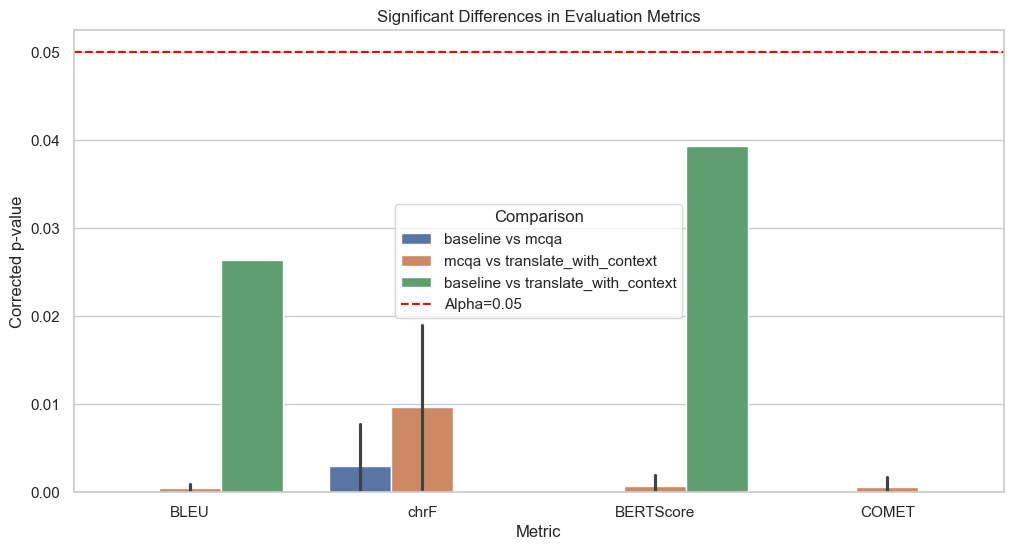

In [119]:
# Filter significant results
significant_results = test_results_df[test_results_df['Significant'] == True]

# Plotting significant differences
plt.figure(figsize=(12, 6))
sns.barplot(
    data=significant_results,
    x='Metric',
    y='p-value_corrected',
    hue='Comparison'
)
plt.axhline(y=0.05, color='red', linestyle='--', label='Alpha=0.05')
plt.title('Significant Differences in Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Corrected p-value')
plt.legend(title='Comparison')
plt.show()
